<div align="center"> 
    <hr>
  <font size="6"><b>Dev | Clean-Clean Entity Resolution Notebook</b> </font>
   <hr>
</div>

In [1]:
!python --version

Python 3.10.9


In [2]:
import os
import sys
import pandas as pd
import networkx
from networkx import draw, Graph
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from pyjedai.utils import (
    text_cleaning_method,
    print_clusters,
    print_blocks,
    print_candidate_pairs
)
from pyjedai.evaluation import Evaluation, write
from pyjedai.datamodel import Data
d1 = pd.read_csv("data/ccer/D2/abt.csv", sep='|', engine='python', na_filter=False).astype(str)
d2 = pd.read_csv("data/ccer/D2/buy.csv", sep='|', engine='python', na_filter=False).astype(str)
gt = pd.read_csv("data/ccer/D2/gt.csv", sep='|', engine='python')

data = Data(
    dataset_1=d1,
    attributes_1=['id','name','description'],
    id_column_name_1='id',
    dataset_2=d2,
    attributes_2=['id','name','description'],
    id_column_name_2='id',
    ground_truth=gt,
)

# Block Building

In [3]:
from pyjedai.block_building import (
    StandardBlocking,
    QGramsBlocking,
    ExtendedQGramsBlocking,
    SuffixArraysBlocking,
    ExtendedSuffixArraysBlocking,
)

In [4]:
qgb = QGramsBlocking(qgrams=6)
blocks = qgb.build_blocks(data, attributes_1=['name'], attributes_2=['name'])

Q-Grams Blocking:   0%|          | 0/2152 [00:00<?, ?it/s]

In [5]:
qgb.evaluate(blocks, with_classification_report=True)

***************************************************************************************************************************
                                         Μethod:  Q-Grams Blocking
***************************************************************************************************************************
Method name: Q-Grams Blocking
Parameters: 
	Q-Gramms: 6
Runtime: 0.0801 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:      0.32% 
	Recall:        99.91%
	F1-score:       0.63%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Classification report:
	True positives: 1075
	False positives: 337743
	True negatives: 820032
	False negatives: 1
	Total comparisons: 338818
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


{'Precision %': 0.3172794833804579,
 'Recall %': 99.90706319702602,
 'F1 %': 0.6325501479873138,
 'True Positives': 1075,
 'False Positives': 337743,
 'True Negatives': 820032,
 'False Negatives': 1}

# Block Cleaning

In [6]:
from pyjedai.block_cleaning import BlockFiltering

In [7]:
bf = BlockFiltering(ratio=0.8)
filtered_blocks = bf.process(blocks, data, tqdm_disable=False)

Block Filtering:   0%|          | 0/3 [00:00<?, ?it/s]

# Comparison Cleaning


In [8]:
from pyjedai.block_cleaning import BlockPurging

In [9]:
cbbp = BlockPurging()
cleaned_blocks = cbbp.process(filtered_blocks, data, tqdm_disable=False)

Block Purging:   0%|          | 0/5050 [00:00<?, ?it/s]

In [10]:
cbbp.evaluate(cleaned_blocks, with_classification_report=True)

***************************************************************************************************************************
                                         Μethod:  Block Purging
***************************************************************************************************************************
Method name: Block Purging
Parameters: 
	Smoothing factor: 1.025
	Max Comparisons per Block: 3224.0
Runtime: 0.0231 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:      0.94% 
	Recall:        98.33%
	F1-score:       1.87%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Classification report:
	True positives: 1058
	False positives: 110909
	True negatives: 1046849
	False negatives: 18
	Total comparisons: 111967
──────────────────────────────────────────────────────────────────────────────────────────

{'Precision %': 0.944921271446051,
 'Recall %': 98.3271375464684,
 'F1 %': 1.8718540732287712,
 'True Positives': 1058,
 'False Positives': 110909,
 'True Negatives': 1046849,
 'False Negatives': 18}

# Progressive Entity Matching

Applies Entity Matching to a subset of candidate pairs based on prioritization scheme.

In [11]:
from pyjedai.prioritization import (
    GlobalTopPM,
    LocalTopPM,
    EmbeddingsNNBPM,
    GlobalPSNM,
    LocalPSNM,
    RandomPM,
    PESM
)

In [12]:
%%time
LTPM = LocalTopPM(
    budget = 10000,
    w_scheme = 'X2',
    metric='dice',
    similarity_threshold=0.1,
    attributes = ['description', 'name']
)

ltpm_pairs_graph = LTPM.predict(cleaned_blocks, data, tqdm_disable=True)

CPU times: user 2.43 s, sys: 5.51 ms, total: 2.44 s
Wall time: 2.42 s


In [13]:
%%time
GTPM = GlobalTopPM(
    budget = 10000,
    w_scheme = 'X2',
    metric='dice',
    similarity_threshold=0.1,
    attributes = ['description', 'name']
)

gtpm_pairs_graph = GTPM.predict(cleaned_blocks, data, tqdm_disable=True)

CPU times: user 1.33 s, sys: 7.29 ms, total: 1.34 s
Wall time: 1.33 s


In [14]:
%%time
GPSNM = GlobalPSNM(
    budget = 10000,
    pwScheme = 'ID',
    metric='dice',
    similarity_threshold=0.1,
    attributes = ['description', 'name']
)

gpsnm_pairs_graph = GPSNM.predict(cleaned_blocks, data, tqdm_disable=True)

CPU times: user 384 ms, sys: 0 ns, total: 384 ms
Wall time: 384 ms


In [15]:
%%time
LPSNM = LocalPSNM(
    budget = 10000,
    pwScheme = 'ID',
    metric='dice',
    similarity_threshold=0.1,
    attributes = ['description', 'name']
)

lpsnm_pairs_graph = LPSNM.predict(cleaned_blocks, data, tqdm_disable=True)

CPU times: user 68.8 ms, sys: 6 µs, total: 68.8 ms
Wall time: 68.4 ms


In [16]:
%%time
ENNBPM = EmbeddingsNNBPM(
    budget = 10000,
    vectorizer = 'sminilm',
    similarity_search = 'faiss',
    emission= 'top',
    metric = 'dice',
    tokenizer = 'white_space_tokenizer',
    similarity_threshold = 0.1
)
ennbpm_pairs_graph = ENNBPM.predict(cleaned_blocks, data, tqdm_disable=True)

Embeddings-NN Block Building [sminilm, faiss]:   0%|          | 0/2152 [00:00<?, ?it/s]

Device selected:  cpu
Loading embeddings from file...
Loading file:  .embeddings/sminilm_d1_1.npy
Embeddings not found. Creating new ones.
Loading file:  .embeddings/sminilm_d2_2.npy
Embeddings not found. Creating new ones.
Loading embeddings from file finished
Saving embeddings...
Saving file:  .embeddings/d1_1.npy
Saving file:  .embeddings/d2_2.npy
CPU times: user 9min 6s, sys: 8.17 s, total: 9min 15s
Wall time: 1min 10s


In [17]:
%%time
rpm = RandomPM(
    budget = 10000,
    metric='dice',
    similarity_threshold=0.1,
    attributes = ['description', 'name']
)

rpm_pairs_graph = rpm.predict(cleaned_blocks, data, tqdm_disable=True)

CPU times: user 306 ms, sys: 4.35 ms, total: 310 ms
Wall time: 38.8 ms


In [18]:
%%time
pesm = PESM(
    budget = 10000,
    w_scheme = 'X2',
    metric='dice',
    similarity_threshold=0.1,
    attributes = ['description', 'name']
)

pesm_pairs_graph = pesm.predict(cleaned_blocks, data, tqdm_disable=True, method='BFS')

CPU times: user 4.94 s, sys: 56 ms, total: 5 s
Wall time: 4.53 s


In [20]:
def reverse(id1, id2):
    if(id1 > id2):
        return (id2, id1)
    else:
        return (id1, id2)

def get_duplicates(tuple_list):
    count = 0
    seen_pairs = set()
    duplicates = []
    
    for item in tuple_list:
        weight, id1, id2 = item
        pair = reverse(id1, id2)
        
        if pair in seen_pairs:
            dupl.append(pair)
        else:
            seen_pairs.add(pair)
    
    return duplicates

In [36]:
# some progressive methods don't allow for comparison storage within graph
# it changes the order of the emitted pairs
methods_prediction_data = []

# ltpm_pairs_graph.edges = sorted(ltpm_pairs_graph.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)
# gtpm_pairs_graph.edges = sorted(gtpm_pairs_graph.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)

# ltpm_pairs_graph.edges = [edge[:2] for edge in ltpm_pairs_graph.edges]
# gtpm_pairs_graph.edges = [edge[:2] for edge in gtpm_pairs_graph.edges]


# ltpm_pairs_graph
# gtpm_pairs_graph
# rpm_pairs_graph
# gpsnm_pairs_graph
# lpsnm_pairs_graph
# pesm_pairs_graph

methods_prediction_data.append(("Random", [edge for edge in rpm_pairs_graph.edges]))
methods_prediction_data.append(("Local Top", [edge[:2] for edge in ltpm_pairs_graph.edges]))
methods_prediction_data.append(("Global Top", [edge[:2] for edge in gtpm_pairs_graph.edges]))
methods_prediction_data.append(("GSN", gpsnm_pairs_graph))
methods_prediction_data.append(("LSN", lpsnm_pairs_graph))
methods_prediction_data.append(("ES", pesm_pairs_graph))
methods_prediction_data.append(("ENNBPM", ennbpm_pairs_graph))

190
190
919 199
919 633
919 531
919 1022
919 980
FOUND: 919 980
919 665
919 806
284 199
993 199
326 199
557 199
1017 199
825 199
834 287
834 506
834 328
834 262
834 198
834 285
834 28
834 12
596 287
1036 287
453 287
756 813
756 403
756 386
756 47
756 424
756 396
756 828
756 547
756 676
756 303
756 239
658 813
430 813
1051 813
103 813
114 813
1032 342
1032 943
1032 721
1032 859
1032 122
1032 27
1032 651
1032 117
1032 706
1032 728
1032 239
1032 790
1032 1005
1032 373
1032 1011
1032 237
1032 797
1032 638
1032 698
1032 901
1032 593
1032 826
1032 663
1032 914
492 342
462 342
311 342
857 342
691 342
644 342
609 342
684 342
1058 342
732 342
37 342
440 342
396 342
212 342
61 342
577 342
1020 214
1020 8
FOUND: 1020 8
1020 132
1020 26
1020 209
1020 225
1020 669
1020 91
214 214
718 214
519 214
106 214
690 214
696 214
702 214
698 214
786 214
664 764
664 382
664 360
664 681
664 918
664 721
664 1018
664 618
664 706
664 237
664 631
664 151
664 409
664 1056
664 514
664 566
664 208
664 981
664 977
664 

203 527
204 271
FOUND: 204 271
204 27
204 203
204 254
204 260
204 282
204 285
204 352
204 444
204 470
204 478
204 647
204 762
204 920
204 928
204 986
204 1013
205 263
FOUND: 205 263
205 260
205 117
205 182
205 261
205 266
205 282
205 379
205 392
205 429
205 478
205 1020
205 1036
205 1044
206 216
FOUND: 206 216
206 302
206 307
206 354
206 369
206 415
206 455
206 461
206 630
206 754
206 781
207 182
FOUND: 207 182
207 241
207 310
207 1014
207 1054
208 255
208 256
208 260
208 353
208 525
208 1027
209 451
209 469
FOUND: 209 469
209 362
209 473
209 483
209 490
209 1045
210 861
210 40
210 312
210 316
210 317
210 318
FOUND: 210 318
210 322
210 859
211 758
211 6
211 175
211 315
211 317
211 321
211 323
211 559
211 862
211 1072
212 6
212 77
212 230
212 248
212 315
212 316
212 317
212 318
212 341
212 511
212 513
212 861
213 77
213 175
213 271
213 315
213 322
213 323
FOUND: 213 323
213 511
213 862
214 3
FOUND: 214 3
214 14
214 26
214 181
214 226
214 280
214 761
214 1040
214 1057
215 14
215 196
215 

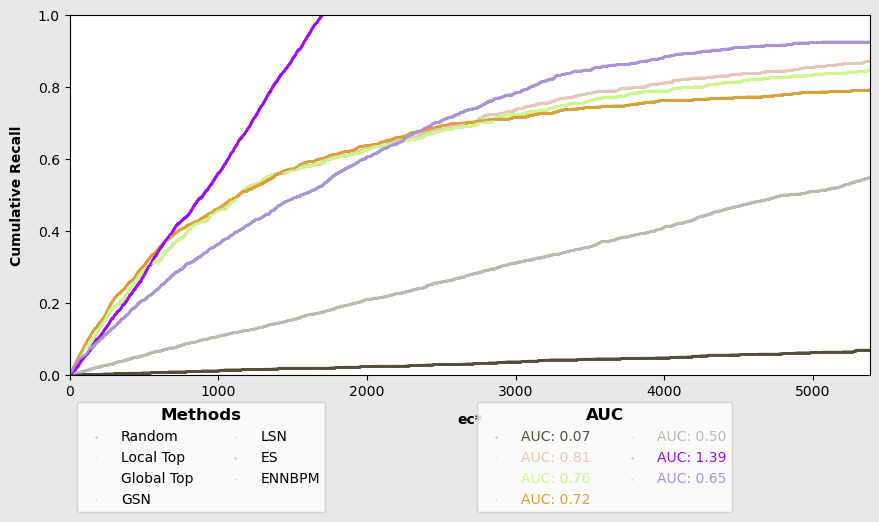

CPU times: user 905 ms, sys: 12 ms, total: 917 ms
Wall time: 914 ms


In [49]:
%%time
GPSNM.evaluate_auc_roc(methods_prediction_data = methods_prediction_data, proportional = False, stop_on_tps_found = True)

In [ ]:
919 1275
919 199
919 1709
919 633
919 1607
919 531
919 2098
919 1022
919 2056
919 980
919 1741
919 665
919 1882
919 806


919 199
HA
919 633
HA
919 531
HA
919 1022
HA
919 980
HA
919 665
HA
919 806
HA
284 199

919 199
919 633
919 531
919 1022
919 980
919 665
919 806
284 199
993 199
326 199
557 199
1017 199
825 199
834 287


E(919) C(1275) Em(1) TPF(0)
E(919) C(1709) Em(2) TPF(0)
E(919) C(1607) Em(3) TPF(0)
E(919) C(2098) Em(4) TPF(0)
E(919) C(2056) Em(5) TPF(0)
E(919) C(1741) Em(6) TPF(0)
E(919) C(1882) Em(7) TPF(0)
E(1275) C(284) Em(8) TPF(0)
E(1275) C(993) Em(9) TPF(0)

# Entity Clustering

It takes as input the similarity graph produced by Entity Matching and partitions it into a set of equivalence clusters, with every cluster corresponding to a distinct real-world object.

In [ ]:
from pyjedai.clustering import ConnectedComponentsClustering, UniqueMappingClustering

In [ ]:
ccc = ConnectedComponentsClustering()
clusters = ccc.process(pairs_graph, data)

In [ ]:
ccc.evaluate(clusters, with_classification_report=True)

In [ ]:
from pyjedai.clustering import ConnectedComponentsClustering, UniqueMappingClustering
umc = UniqueMappingClustering()
clusters = umc.process(pairs_graph, data)

In [ ]:
umc.evaluate(clusters, with_classification_report=True)